## Loading dataset from kaggle + Inspecting

In [1]:
# Loading data from kaggle
import kagglehub
path =  kagglehub.dataset_download("apollo2506/eurosat-dataset")
print(path)

100%|██████████| 2.04G/2.04G [00:25<00:00, 84.6MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [2]:
import os
os.listdir(path)

['EuroSAT', 'EuroSATallBands']

In [3]:
base_dir = os.path.join(path, "EuroSAT")
os.listdir(base_dir)

['HerbaceousVegetation',
 'River',
 'test.csv',
 'AnnualCrop',
 'train.csv',
 'PermanentCrop',
 'label_map.json',
 'Pasture',
 'Industrial',
 'Highway',
 'validation.csv',
 'Forest',
 'SeaLake',
 'Residential']

In [4]:
# Class count
class_counts = {}

for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category) #join base + category_name to get category_path
    if os.path.isdir(category_path): #if category_path is a directory
      class_counts[category] = len(os.listdir(category_path)) # Count no. images inside the category_path

class_counts

{'HerbaceousVegetation': 3000,
 'River': 2500,
 'AnnualCrop': 3000,
 'PermanentCrop': 2500,
 'Pasture': 2000,
 'Industrial': 2500,
 'Highway': 2500,
 'Forest': 3000,
 'SeaLake': 3000,
 'Residential': 3000}

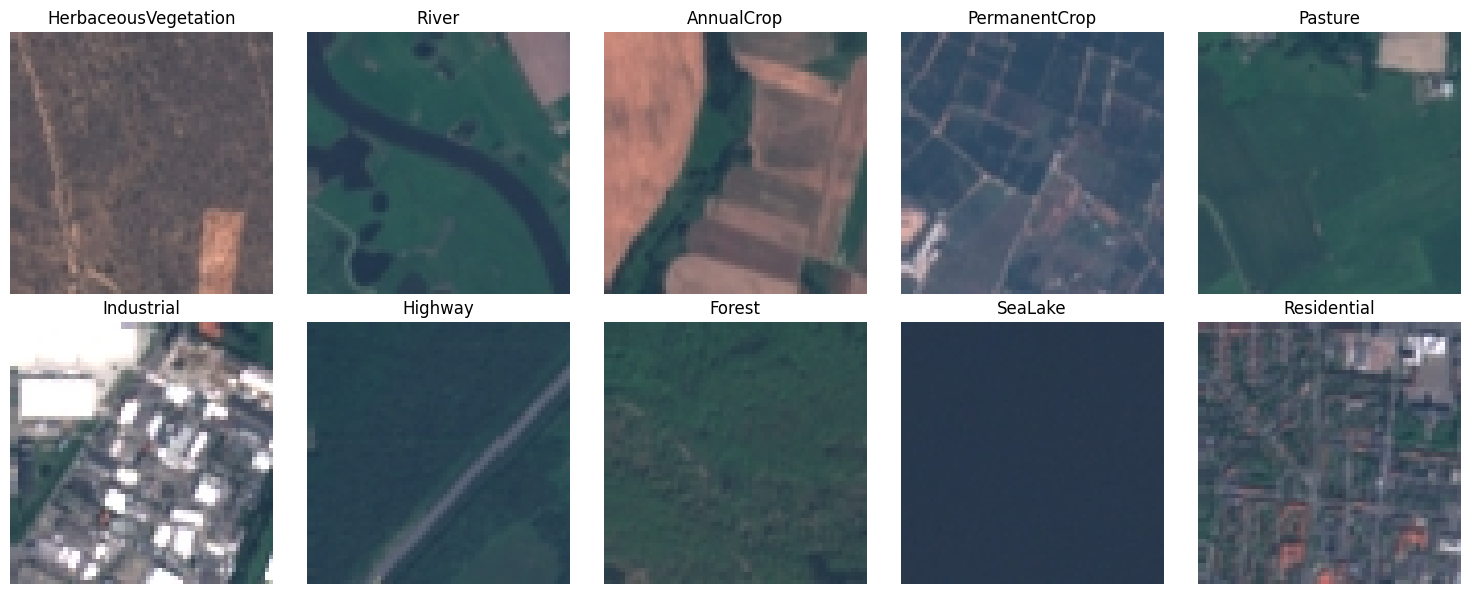

In [5]:
# Display images
import random
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten() #Flatten 2x5 axes list into 1x10 axes list

for ax, category in zip(axes, class_counts.keys()):
    category_path = os.path.join(base_dir, category) # join base + category_name to get category_path
    img_name = random.choice(os.listdir(category_path)) # Choose a random img
    img_path = os.path.join(base_dir, category, img_name) # join base + category_name + img_name to get Image path
    img = Image.open(img_path)

    ax.imshow(img)
    ax.set_title(category)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Creating Train and validation dataset

In [13]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="categorical" #one-got encode labels
)

# test dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    label_mode="categorical" #one-got encode labels
)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [14]:
# Class labels
train_ds.class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [15]:
# Performance optimization
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Defining model

In [16]:
# Data Augumentation layers
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [17]:
# Base model - EfficientNet
from tensorflow.keras import models

base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False, # Disable Imagenet classifer trained on 1000 classes
    weights="imagenet" #Use pretained weights of imagenet
)

base_model.trainable = False #Freeze convolutional layers

In [18]:
# Full model
inputs = layers.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x) #EfficientNet-specific input processing

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = models.Model(inputs, outputs)

In [19]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,254,938 (23.86 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 5,921,872 (22.59 MB)

## Phase 1 :- Train the Classifer head

In [21]:
with tf.device("/device:GPU:0"):
  history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 85ms/step - accuracy: 0.8259 - loss: 0.5698 - val_accuracy: 0.9402 - val_loss: 0.1903
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.9077 - loss: 0.3040 - val_accuracy: 0.9509 - val_loss: 0.1425
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.9200 - loss: 0.2401 - val_accuracy: 0.9530 - val_loss: 0.1345
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.9280 - loss: 0.2177 - val_accuracy: 0.9546 - val_loss: 0.1365
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.9320 - loss: 0.2042 - val_accuracy: 0.9607 - val_loss: 0.1196
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.9298 - loss: 0.2103 - val_accuracy: 0.9576 - val_loss: 0.1248
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.9344 - loss: 0.2026 - val_accuracy: 0.9593 - val_loss: 0.1222
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.9331 - loss: 0.2005 - 

In [24]:
history.history

{'accuracy': [0.8711110949516296,
  0.9105092883110046,
  0.9218518733978271,
  0.9274073839187622,
  0.9327777624130249,
  0.9307407140731812,
  0.9339814782142639,
  0.9355092644691467,
  0.9391666650772095,
  0.9361574053764343],
 'loss': [0.4256627559661865,
  0.29023638367652893,
  0.2438672035932541,
  0.22265195846557617,
  0.20386219024658203,
  0.21096757054328918,
  0.19706788659095764,
  0.1894838809967041,
  0.18619908392429352,
  0.19884905219078064],
 'val_accuracy': [0.9401851892471313,
  0.9509259462356567,
  0.9529629349708557,
  0.9546296000480652,
  0.9607407450675964,
  0.9575926065444946,
  0.9592592716217041,
  0.9611111283302307,
  0.9614814519882202,
  0.9572222232818604],
 'val_loss': [0.19025227427482605,
  0.1424589604139328,
  0.13450874388217926,
  0.13653896749019623,
  0.11959528177976608,
  0.12476832419633865,
  0.1221848577260971,
  0.11888545006513596,
  0.11719021201133728,
  0.12240353971719742]}

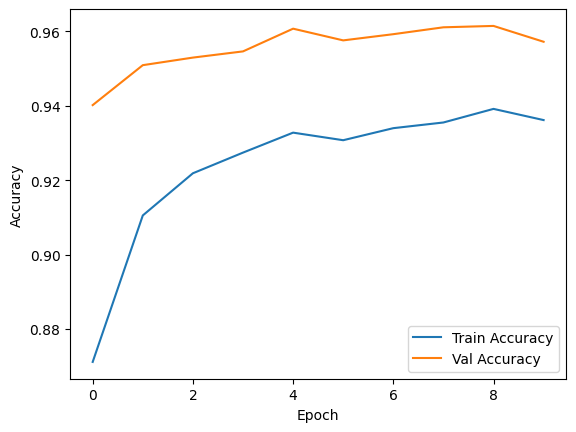

In [31]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

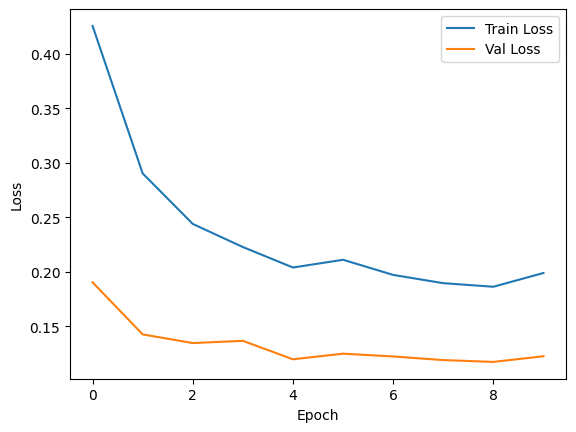

In [32]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Phase 2 - Fine tunning by partial unfreeze

In [42]:
# Unfreeze part of the backbone, here we wil unfreeze only the top 30% of the layers
# top layers (closer to o/p) = task specific layers -> need to fine-tune by unfreezing them
# bottom layers (closer to input) = edges/textures layers -> generic layers and no need to fine-tune them

# Redefining base model
base_model.trainable = True

# Freeze bottom 70% layers and unfreeze the top 30% layers
fine_tune_at = int(len(base_model.layers)*0.7)

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [43]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [44]:
# Train model again to fine tune
with tf.device("/device:GPU:0"):
  history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 106s 124ms/step - accuracy: 0.8989 - loss: 0.3075 - val_accuracy: 0.9598 - val_loss: 0.1195
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - accuracy: 0.9425 - loss: 0.1841 - val_accuracy: 0.9672 - val_loss: 0.0994
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - accuracy: 0.9490 - loss: 0.1599 - val_accuracy: 0.9717 - val_loss: 0.0857
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 118ms/step - accuracy: 0.9542 - loss: 0.1383 - val_accuracy: 0.9698 - val_loss: 0.0942
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 118ms/step - accuracy: 0.9611 - loss: 0.1155 - val_accuracy: 0.9722 - val_loss: 0.0875
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 119ms/step - accuracy: 0.9627 - loss: 0.1019 - val_accuracy: 0.9704 - val_loss: 0.0894
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 118ms/step - accuracy: 0.9653 - loss: 0.1067 - val_accuracy: 0.9739 - val_loss: 0.0810
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 118ms/step - accuracy: 0.9691 - loss: 

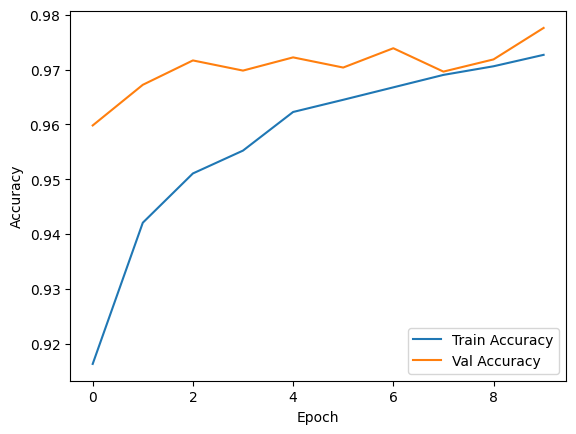

In [45]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

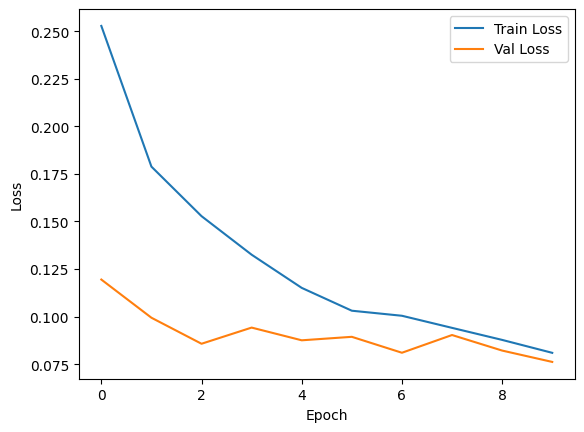

In [46]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [47]:
# save model
model.save("eurosat_efficientnetv2b0.keras")

## Model Evaluation

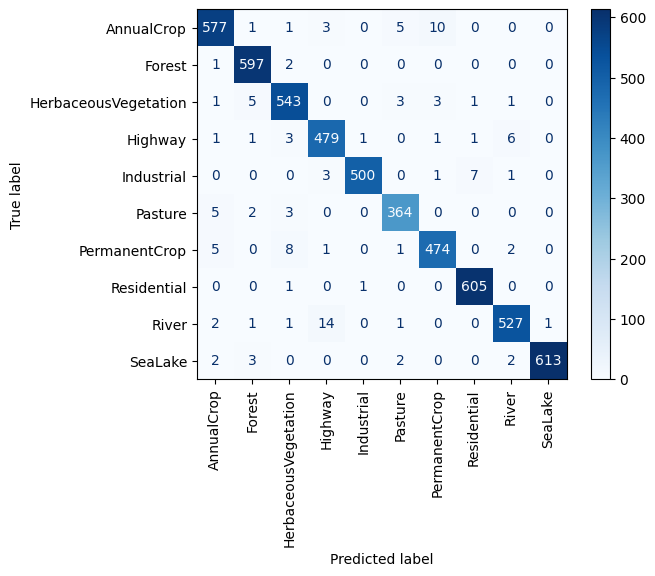

In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Calculating y_true and y_pred arrays
y_true = []
y_pred = []

for images, labels in val_ds:
  preds = model.predict(images, verbose=False)
  y_true.extend(np.argmax(labels.numpy(), axis=1)) # argmax() gives the index of the largest value
  y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Build confusion matrix
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(cmap="Blues", xticks_rotation=90)

In [65]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       597
           1       0.98      0.99      0.99       600
           2       0.97      0.97      0.97       557
           3       0.96      0.97      0.96       493
           4       1.00      0.98      0.99       512
           5       0.97      0.97      0.97       374
           6       0.97      0.97      0.97       491
           7       0.99      1.00      0.99       607
           8       0.98      0.96      0.97       547
           9       1.00      0.99      0.99       622

    accuracy                           0.98      5400
   macro avg       0.98      0.98      0.98      5400
weighted avg       0.98      0.98      0.98      5400

